In [2]:
import numpy as np
import timeit
import networkx as nx
import importlib.util
import matplotlib.pyplot as plt


import numpy.linalg as la
import scipy


# Funcion "Coordinate descent"

### Funciones auxiliares

In [3]:
def cost_function(A,X,M):
    """
    RDPG cost function ||(A-XX^T)*M||_F^2
    where * is the entry-wise product.

    Parameters
    ----------
    A : matrix nxn
    X : matrix of embeddings
    M : mask matrix nxn
        
    Returns
    -------
    value of ||(A-XX^T)*M||_F^2
    """
    return 0.5*np.linalg.norm((A - X@X.T)*M,ord='fro')**2

def solve_linear_system(A,b,xx):
    """
    Linear system solver, used in several methods.
    Should you use another method for solving linear systems, just change this function.
    
    Returns the solution of Ax=b
    Parameters
    ----------
    A : matrix nxn
    b : vector 

    Returns
    -------
    vector x
        solution to Ax=b

    """
    try:
        result = scipy.linalg.solve(A,b)
    except:
        result = scipy.sparse.linalg.minres(A,b,xx)[0]    
    return result

### Funcion principal

$min ||(A-XX^T)*M||_F^2$

In [4]:
def coordinate_descent(A,d,X=None,tol=1e-5):

    ## Modificado con los errores

    n=A.shape[0]
    M = np.ones(n) - np.eye(n)
    if X is None:
        X = np.random.rand(n,d)
    else:
        X = X.copy()
    
    R = X.T@X
    fold = -1

    errores = []

    iter = 0
    while (abs((fold - cost_function(A, X, M))/fold) >tol):

        fold = cost_function(A, X, M)
        for i in range(n):
            k=X[i,:][np.newaxis]  #(fila i)^t . (fila i)
            R -= k.T@k
            X[i,:] = solve_linear_system(R,(A[i,:]@X).T,X[i,:])
            k=X[i,:][np.newaxis]
            R += k.T@k
        err = abs((fold - cost_function(A, X, M))/fold)
        errores = errores + [err]
        print("Iteracion: " + str(iter) + " | Error relativo: " + str(err) + " | norma R: " + str(la.norm(R)))
        iter +=1
    return (X, errores)

### Ejemplo

In [5]:
gy=0
if importlib.util.find_spec('graspologic') is None:
    print("graspologic is not installed. Running the other methods.")
else:
    gy=1
    import graspologic as gy

##%%
def embed_scipy(A, K):
    UA, SA, VAt = scipy.linalg.svd(A)
    XA = UA[:,0:K].dot(np.diag(np.sqrt(SA[0:K])))    
    return XA

graspologic is not installed. Running the other methods.


In [6]:
p1 = [[0.5, 0.2],
      [0.2, 0.5]]
d=5
n_list = [1800, 1200]

nt=np.sum(n_list)
g = nx.stochastic_block_model(n_list,p1)
A_original = nx.to_numpy_array(g)
M_original = np.ones(nt) - np.eye(nt)
X_original = np.random.rand(A_original.shape[0],d)


Running Coordinate descent
Iteracion: 0 | Error relativo: 0.7990312215376101 | norma R: 646.6918444020931
Iteracion: 1 | Error relativo: 0.19986859479541422 | norma R: 1234.4625524394487
Iteracion: 2 | Error relativo: 0.012954619655548736 | norma R: 1161.2802360968892
Iteracion: 3 | Error relativo: 0.0006069044539347602 | norma R: 1161.4103201626463
Iteracion: 4 | Error relativo: 0.00020262483519117584 | norma R: 1163.5207078941148
Iteracion: 5 | Error relativo: 0.00012525556956720298 | norma R: 1163.5560489029137
Iteracion: 6 | Error relativo: 8.620456124430082e-05 | norma R: 1163.5404905188595
Iteracion: 7 | Error relativo: 6.208743280258402e-05 | norma R: 1163.5954553678434
Iteracion: 8 | Error relativo: 4.599107764109269e-05 | norma R: 1163.6346784156613
Iteracion: 9 | Error relativo: 3.480104007922728e-05 | norma R: 1163.6612290126288
Iteracion: 10 | Error relativo: 2.6809676331763198e-05 | norma R: 1163.6819653137024
Iteracion: 11 | Error relativo: 2.098832562452264e-05 | norma R

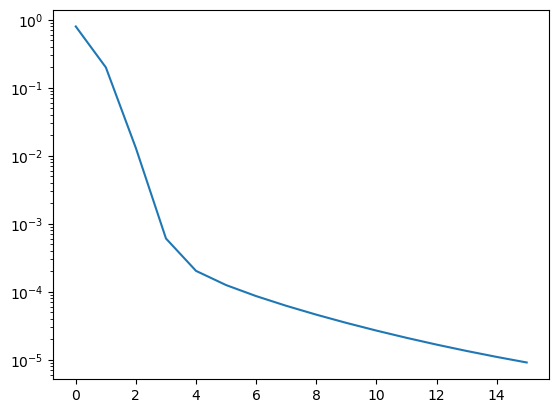

In [7]:
A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Coordinate descent")
start_cd = timeit.default_timer()
(X_cd, errores) = coordinate_descent(A,d)
stop_cd = timeit.default_timer()
time_cd = round(stop_cd-start_cd,3)
print("Done in ",time_cd," seconds.\n")

print("Running Scipy SVD")
start_scipy = timeit.default_timer()
X_scipy = embed_scipy(A,d)
stop_scipy = timeit.default_timer()
time_scipy = round(stop_scipy-start_scipy,3)
print("Done in ",time_scipy," seconds.\n")

if gy:
    print("Running Gaspologic ASE")
    ase = gy.embed.AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
    start_gy = timeit.default_timer()
    X_gy = ase.fit_transform(A)
    stop_gy = timeit.default_timer()
    time_gy = round(stop_gy-start_gy,3)
    print("Done in ",time_gy," seconds.\n")

##%%
print("Method                        Time (s) \t Cost function ||(A-XX^T)*M||_F^2",)
print("---------------------------------------------------------------------",)
print("Coordinate descent            ",time_cd,"\t\t", cost_function(A,X_cd,M))
print("Scipy                         ",time_scipy,"\t\t", cost_function(A,X_scipy,M))
if gy: print("Graspologic                   ",time_gy,"\t\t", cost_function(A,X_gy,M))

plt.plot(errores)
plt.yscale('log')
x_star = X_cd

### Intento de paralelizar filas de X


In [101]:
import copy

In [139]:
def coordinate_descent_random_filas(A,d,X=None,tol=1e-5):

    ## Modificado con los errores

    n=A.shape[0]
    M = np.ones(n) - np.eye(n)
    if X is None:
        X = np.random.rand(n,d)
    else:
        X = X.copy()
    
    
    fold = -1

    errores = []
    
    iter = 0
    while (abs((fold - cost_function(A, X, M))/fold) >tol):

        fold = cost_function(A, X, M)
        
        corrs = random.sample(range(n), int(n/8))

        R_o = X.T@X
        X_acc =  copy.deepcopy(X)
        
        for i in corrs:
            R = copy.deepcopy(R_o)
            X_int =  copy.deepcopy(X)
            k=X_int[i,:][np.newaxis]  #(fila i)^t . (fila i)
            R -= k.T@k
            X_acc[i,:] = solve_linear_system(R,(A[i,:]@X_int).T,X_int[i,:])
            
        X = X_acc
        err = cost_function(A, X, M)
        errores = errores + [err]
        print("Iteracion: " + str(iter) + " | Error relativo: " + str(err) + " | norma R: " + str(la.norm(R_o)))
        iter +=1
    return (X, errores)

In [140]:
A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Coordinate descent")
start_cd_r = timeit.default_timer()
(X_cd_r, errores) = coordinate_descent_random_filas(A,d)
stop_cd_r = timeit.default_timer()
time_cd_r = round(stop_cd_r-start_cd_r,3)
print("Done in ",time_cd_r," seconds.\n")

##%%
print("Method                        Time (s) \t Cost function ||(A-XX^T)*M||_F^2",)
print("---------------------------------------------------------------------",)
print("Coordinate descent random            ",time_cd_r,"\t\t", cost_function(A,X_cd_r,M))




Running Coordinate descent
Iteracion: 0 | Error relativo: 4581765.134730115 | norma R: 4002.442111489593
Iteracion: 1 | Error relativo: 3832706.6280905562 | norma R: 3541.1435948294425
Iteracion: 2 | Error relativo: 3204001.073634875 | norma R: 3162.8697560599153
Iteracion: 3 | Error relativo: 2737880.7189026223 | norma R: 2809.6586460326944
Iteracion: 4 | Error relativo: 2363038.1121802633 | norma R: 2506.2568856631165
Iteracion: 5 | Error relativo: 2091857.4259048298 | norma R: 2232.431728377303
Iteracion: 6 | Error relativo: 1892033.8860315634 | norma R: 2005.9293075252815
Iteracion: 7 | Error relativo: 1711844.800558861 | norma R: 1822.6637995134852
Iteracion: 8 | Error relativo: 1589091.3682943303 | norma R: 1645.4780193854372
Iteracion: 9 | Error relativo: 1484526.3972157582 | norma R: 1522.1830978172668
Iteracion: 10 | Error relativo: 1401191.6100659037 | norma R: 1416.1286454838275
Iteracion: 11 | Error relativo: 1328840.7167413877 | norma R: 1333.4428243423324
Iteracion: 12 | 

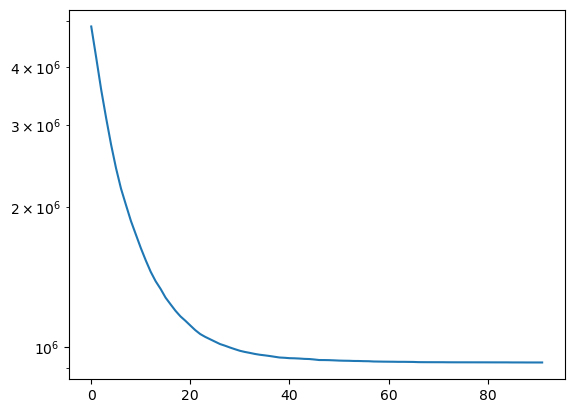

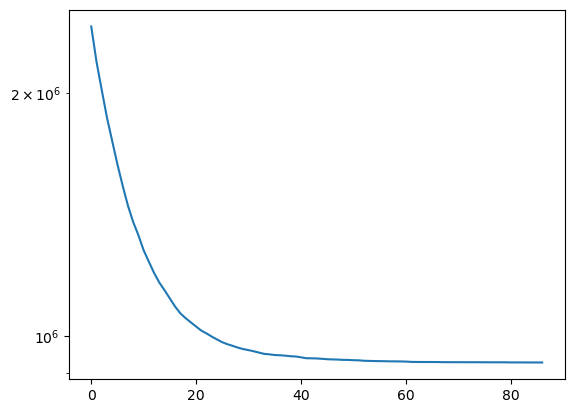

In [115]:
plt.plot(errores)
plt.yscale('log')
plt.show()


plt.plot(errores[5:])
plt.yscale('log')
plt.show()
x_star = X_cd_r

### Tercera idea

Luego de la reunion con Ernesto el 18/4, se propuso la idea de intentar ver si varios hilos calculan cada iteracion utilizando como regiones criticas la actualizacion de R.

En mi opinion tambien se deberia poner la linea " X[i,:] = solve_linear_system(R,(A[i,:]@X).T,X[i,:]) " como zona critica, ya que se consume R, pero en caso de hacer eso no tiene sentido papralelizar.

IMPORTANTE: Probe sin el mutex y tambien funciona, no entiendo muy bien como.



In [8]:
import threading

## Implementamos el metodo, utilizando varios hilos

In [9]:

lock_R = threading.Lock()

def coordinate_descent_MODIFICADO_3_per_thread(i, seriales):
    global X
    global R
    global A
    global finish
    global barrier_descent
    
    while not finish:     
        
        if seriales:
            with lock_R as l:
                k=X[i,:][np.newaxis]  #(fila i)^t . (fila i)
                R -= k.T@k
                sol = solve_linear_system(R,(A[i,:]@X).T,X[i,:])
            
                X[i,:] = sol
                k=X[i,:][np.newaxis]
            
                R += k.T@k
            barrier_descent.wait()

        else:
            k=X[i,:][np.newaxis]  #(fila i)^t . (fila i)
            R -= k.T@k
            sol = solve_linear_system(R,(A[i,:]@X).T,X[i,:])
        
            X[i,:] = sol
            k=X[i,:][np.newaxis]
        
            R += k.T@k
            barrier_descent.wait()
    

def update_finish_descent(max_iteraciones, tolerancia):
    def ineer_update():
        global finish 
        global fold
        global err_current_iteracion_decent
        global X
        global R
        global A
        global M
        global iter
        
        finish = not ((max_iteraciones is None or iter < max_iteraciones) and abs((fold - cost_function(A, X, M)) / fold) > tolerancia)
        err_current_iteracion_decent = abs((fold - cost_function(A, X, M))/fold)
        fold = cost_function(A, X, M)
        
    
    return  ineer_update


def coordinate_descent_MODIFICADO_3(max_iteraciones, calculoSerial=False, tol=1e-5):
    global X
    global R
    global A

    global lock_R
    lock_R = threading.Lock()

    n=A.shape[0]
    M = np.ones(n) - np.eye(n)
    R = X.T@X
    
    global fold
    fold = -1
    
    global barrier_descent
    barrier_descent = threading.Barrier(n + 1, action=update_finish_descent(max_iteraciones, tol))

    errores = []
    
    global finish
    finish = False
    
    ths = []
    for i in range(n):
        ths.append(threading.Thread(target = coordinate_descent_MODIFICADO_3_per_thread, args = (i,calculoSerial,)))

    for i in range(n):            
        ths[i].start()    

    global err_current_iteracion_decent
    err_current_iteracion_decent = 0


    global iter
    iter = 0
    while not finish:            
        barrier_descent.wait()
           
        errores.append(err_current_iteracion_decent)
        iter +=1
        print("Iteracion: " + str(iter) + " | Error: " + str(err_current_iteracion_decent) + " | norma R: " + str(la.norm(R)))

    return (X, errores)

#### Llamada al metodo, utilizando calculo paralelo (Maximo 51 iteraciones)

Running Coordinate descent Modificado 3 (PARALELO)
Iteracion: 1 | Error: 1159549.2354179602 | norma R: 1287.7830566741497
Iteracion: 2 | Error: 0.3341977835247264 | norma R: 1605.0920265438908
Iteracion: 3 | Error: 0.20239567636647365 | norma R: 916.6042300745655
Iteracion: 4 | Error: 0.02540022398135413 | norma R: 1433.4337197572133
Iteracion: 5 | Error: 0.07384328699762525 | norma R: 1690.5959391027272
Iteracion: 6 | Error: 0.07891569574625669 | norma R: 1520.921189526472
Iteracion: 7 | Error: 0.06881656777445241 | norma R: 1286.120317642125
Iteracion: 8 | Error: 0.05205493631439359 | norma R: 1025.2228963965363
Iteracion: 9 | Error: 0.11446860960323745 | norma R: 1382.8185903517026
Iteracion: 10 | Error: 0.07417684582269814 | norma R: 1443.7944570997754
Iteracion: 11 | Error: 0.11478477789201048 | norma R: 942.9764997876706
Iteracion: 12 | Error: 0.07206855681184808 | norma R: 1309.333216927686
Iteracion: 13 | Error: 0.009054997877460577 | norma R: 1049.0187573569438
Iteracion: 14 |

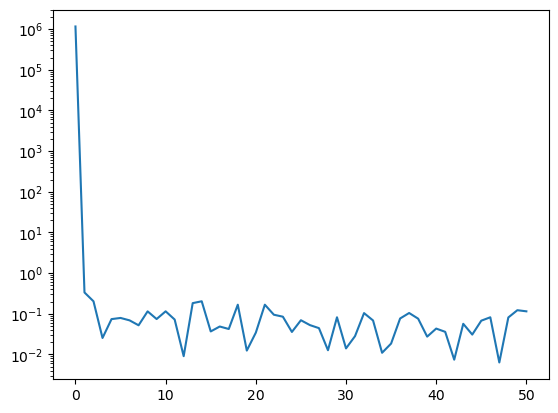

In [10]:

nt=np.sum(n_list)

A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Coordinate descent Modificado 3 (PARALELO)")
start_cd = timeit.default_timer()
(X_cd_S, errores) = coordinate_descent_MODIFICADO_3(50)
stop_cd = timeit.default_timer()
time_cd = round(stop_cd-start_cd,3)
print("Done in ",time_cd," seconds.\n")

plt.plot(errores)
plt.yscale('log')
plt.show()

#### Llamada al metodo, NO paralelo

Running Coordinate descent Modificado 3 (SERIAL)
Iteracion: 1 | Error: 1159476.6788793735 | norma R: 670.3826621661011
Iteracion: 2 | Error: 0.19033159497284582 | norma R: 1238.4571821512338
Iteracion: 3 | Error: 0.01280058697581409 | norma R: 1158.0650929070207
Iteracion: 4 | Error: 0.0006485242782985052 | norma R: 1161.6654860644971
Iteracion: 5 | Error: 0.00019931630743108604 | norma R: 1163.2511094570016
Iteracion: 6 | Error: 0.00011883398630112472 | norma R: 1163.0123706775612
Iteracion: 7 | Error: 7.836237039931547e-05 | norma R: 1163.0769390857856
Iteracion: 8 | Error: 5.488402741375387e-05 | norma R: 1163.2286333491081
Iteracion: 9 | Error: 4.000030474792383e-05 | norma R: 1163.1468023775813
Iteracion: 10 | Error: 3.070451341613801e-05 | norma R: 1163.196396938986
Iteracion: 11 | Error: 2.4314607307745283e-05 | norma R: 1163.188150091361
Iteracion: 12 | Error: 2.0146502301599965e-05 | norma R: 1163.2405683439138
Iteracion: 13 | Error: 1.690224928633319e-05 | norma R: 1163.37205

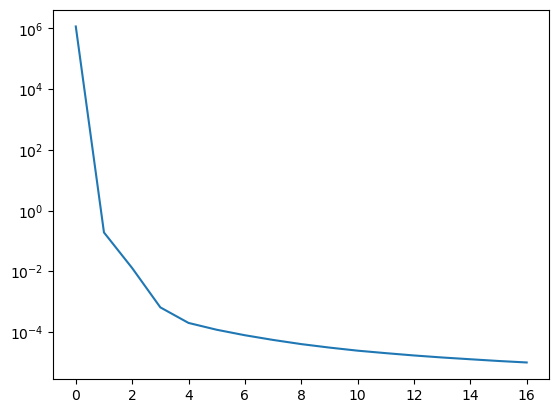

In [11]:
nt=np.sum(n_list)

A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

g = nx.stochastic_block_model(n_list,p1)


print("Running Coordinate descent Modificado 3 (SERIAL)")
start_cd = timeit.default_timer()
(X_cd_S, errores) = coordinate_descent_MODIFICADO_3(50, True)
stop_cd = timeit.default_timer()
time_cd = round(stop_cd-start_cd,3)
print("Done in ",time_cd," seconds.\n")

plt.plot(errores)
plt.yscale('log')
plt.show()